In [3]:
%matplotlib inline
import numpy.random as rand
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy
import pyomo.environ as pyo
import cvxpy as cp
from pyomo.environ import *
from scipy import optimize
from pyomo.opt import SolverFactory
from IPython.display import Markdown, display
import math

In [4]:
## Example 1
# A Pyomo model for the Rosenbrock problem

model = pyo.AbstractModel()
model.name = 'Rosenbrock'

# note boundaries of variables and initial condition $x_0=[-2,2]$
model.x1 = pyo.Var(bounds=(-2,3), initialize=-2)
model.x2 = pyo.Var(bounds=(-2,2), initialize=2)

def rosenbrock(model):
    f = (1.0-model.x1)**2 + 100.0*(model.x2 - model.x1**2)**2
    return f

def ineqconstr(model):
    return model.x2 >= model.x1+1

model.obj = pyo.Objective(rule=rosenbrock, sense=pyo.minimize)
model.constraint = pyo.Constraint(rule=ineqconstr)

In [5]:
# create an instance of the problem
arosenbrockproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
arosenbrockproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(arosenbrockproblem)

# show results
arosenbrockproblem.display()

Model Rosenbrock

  Variables:
    x1 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :    -2 : -0.6147903137877664 :     3 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :    -2 : 0.38520970405541305 :     2 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 2.612793245502972

  Constraints:
    constraint : Size=1
        Key  : Lower : Body                    : Upper
        None :  None : -1.7843179433985057e-08 :   0.0


In [6]:
def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(arosenbrockproblem)


Duals
   Constraint constraint
       None -1.4485148520538937


In [7]:
def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


disp_soln(arosenbrockproblem)


x1 -0.6147903137877664
x2 0.38520970405541305
obj 2.612793245502972


[-0.6147903137877664, 0.38520970405541305, 2.612793245502972]

In [8]:
arosenbrockproblem.x1 = 1.5
arosenbrockproblem.x2 = 1.5

results = opt.solve(arosenbrockproblem)

arosenbrockproblem.display()

Model Rosenbrock

  Variables:
    x1 : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :    -2 : 1.0000000299152387 :     3 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :    -2 :   2.0 :     2 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 99.99998803390469

  Constraints:
    constraint : Size=1
        Key  : Lower : Body                  : Upper
        None :  None : 2.991523873063784e-08 :   0.0


In [9]:
display_lagrange(arosenbrockproblem)

Duals
   Constraint constraint
       None -399.99999594959036


In [10]:
disp_soln(arosenbrockproblem)

x1 1.0000000299152387
x2 2.0
obj 99.99998803390469


[1.0000000299152387, 2.0, 99.99998803390469]

Global Optimisation



In [11]:
num_trials = 10

# random initial starting points (not taking into account additional constraint, pyomo handles that)
x1inits = 5*rand.random_sample((num_trials,))-2
x2inits = 4*rand.random_sample((num_trials,))-2

def get_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
    output.append(pyo.value(instance.obj))
    return output

# record results in tuples of 3 (x1, x1, obj_value)
global_results = np.empty([num_trials, 3])

# main loop of Monte Carlo trials
for index in range(len(x1inits)):
    arosenbrockproblem.x1 = x1inits[index]
    arosenbrockproblem.x2 = x2inits[index]
    opt.solve(arosenbrockproblem)
    global_results[index,:]=np.array(get_soln(arosenbrockproblem))

# rounding to remove unnecessary duplication
round_array = [tuple(row) for row in np.round(global_results, decimals=3)]
# show only different results in rows
np.unique(round_array, axis=0)

array([[ -0.615,   0.385,   2.613],
       [  1.   ,   2.   , 100.   ]])

In [12]:
## Question 3.1.2 (Waterfilling problem)
display(Markdown(r"2. Pyomo"))
rand.seed(8941966)

# A Pyomo model for the Waterfilling problem
model = pyo.AbstractModel()
model.name = 'Waterfilling'
N = 8
P = 1
alpha = np.random.rand(8).flatten()

# note boundaries of variables and initial condition
model.x = pyo.Var(range(N), bounds=(0,None), initialize=0)

def waterfilling(model):
    return sum(-pyo.log(model.x[i] + alpha[i]) for i in range(N))

def eqconstr(model):
    return pyo.summation(model.x) == P

model.obj = pyo.Objective(rule=waterfilling, sense=pyo.minimize)
model.constraint = pyo.Constraint(rule=eqconstr)

# create an instance of the problem
awaterfillingproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
awaterfillingproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(awaterfillingproblem)

# show results
awaterfillingproblem.display()

def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(awaterfillingproblem)

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


disp_soln(awaterfillingproblem)

## Question 3.1.2(Scipy)
display(Markdown(r"2. crosscheck by Scipy"))

def water_filling(n, a, sum_x=1):

    # Declare variables and parameters
    x = cp.Variable(shape=n)
    alpha = cp.Parameter(n, nonneg=True)
    alpha.value = a

    # Choose objective function. Interpret as maximising the total communication rate of all the channels
    obj = cp.Maximize(cp.sum(cp.log(alpha + x)))

    # Declare constraints
    constraints = [x >= 0, cp.sum(x) - sum_x == 0]

    # Solve
    prob = cp.Problem(obj, constraints)
    prob.solve()
    if(prob.status=='optimal'):
        return prob.status, prob.value, x.value
    else:
        return prob.status, np.nan, np.nan

status,value,xx = water_filling(8, alpha, sum_x=1)

display(Markdown(r"$x_i$"))
display(xx)
display(Markdown(r"function value"))
display(-value)

## Question 3.1.3
display(Markdown(r"3. Lagrange multipliers"))
mu = []
lamda = []


for i in range(N):
    if xx[i] > 0.001:
        lamda.append( 1/(alpha[i] + xx[i]) )
    else: lamda.append( lamda[i-1] )

lamda = np.mean(lamda)

for i in range(N):
    if xx[i] > 0.001:
        mu.append( 0 )
    else: mu.append( lamda - 1/(alpha[i] + xx[i]) )

display(Markdown(r"$\mu_i$:"))
display(mu)
display(Markdown(r"$\lambda$:"))
display(lamda)

2. Pyomo

Model Waterfilling

  Variables:
    x : Size=8, Index=x_index
        Key : Lower : Value                : Upper : Fixed : Stale : Domain
          0 :     0 : 0.048695272757921314 :  None : False : False :  Reals
          1 :     0 :   0.2020360373935201 :  None : False : False :  Reals
          2 :     0 :                  0.0 :  None : False : False :  Reals
          3 :     0 :  0.24856334388194198 :  None : False : False :  Reals
          4 :     0 :                  0.0 :  None : False : False :  Reals
          5 :     0 :                  0.0 :  None : False : False :  Reals
          6 :     0 :                  0.0 :  None : False : False :  Reals
          7 :     0 :    0.500705361710903 :  None : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 3.2377439052595065

  Constraints:
    constraint : Size=1
        Key  : Lower : Body               : Upper
        None :   1.0 : 1.00000001

2. crosscheck by Scipy

$x_i$

array([4.86950296e-02, 2.02036113e-01, 1.00588089e-08, 2.48563371e-01,
       1.37278613e-08, 6.03661475e-09, 3.84281684e-09, 5.00705449e-01])

function value

3.2377438804878036

3. Lagrange multipliers

$\mu_i$:

[0,
 0,
 0.4236134598459462,
 0,
 0.3333470745741549,
 0.6000496583945278,
 0.7750344803914384,
 0]

$\lambda$:

1.7958172327901818

1. The problem in Example 3.1 is convex.<br/>
Let's first only consider:<br/>
Objective: $f(x) = -log(\alpha + x)$<br/>
Decision variable(s):  $x_i$<br/>
$\nabla f(x) = -\frac{1}{\alpha + x}$<br/>
$\nabla^2 f(x) = (\frac{1}{\alpha + x})^2 > 0$<br/>
Hence, f(x) is convex.<br/>
By the sum of convex functions is again convex, $g(x_i) = \Sigma_{i=1}^N -log(\alpha_i + x_i)$ is also convex.<br/>

2. Lagrangian: $L(\lambda, \mu_i, x_i) = \Sigma_{i=1}^N -log(\alpha_i + x_i) + \Sigma_{i=1}^N (-\mu_i x_i) + \lambda(\Sigma_{i=1}^N x_i - P)$<br/>
KKT conditions: <br/>
$- \frac{1}{\alpha_i + x_i^*} -  \mu_i + \lambda = 0$<br/>
$-x_i^* \le 0$ <br/>
$\Sigma_{i=1}^N x_i^*- P = 0$ <br/>
$\mu_i \ge 0$ <br/>
$\mu_i x_i^* = 0$ <br/>

3. $\mu_i = [0, 0, 0.4236, 0, 0.3333, 0.6000, 0.7750, 0]$<br/>
$\lambda = 1.79583$

In [13]:
## Question 3.2.1 ( Power Control in Wireless Communication)
display(Markdown(r"2. Pyomo"))
rand.seed(8941966)

# A Pyomo model for the Economic Dispatch in Power Generation problem
model = pyo.AbstractModel()
model.name = '1. Economic Dispatch in Power Generation'
N = 12
P_max = 800*np.random.rand(12).flatten()
c = 10 + 40*np.random.rand(12).flatten()
P_demand = 5000

# note boundaries of variables and initial condition
model.p = pyo.Var(range(N), bounds=(0,None), initialize=0)

def objective(model):
    return sum(c[i]*model.p[i] for i in range(N))

def eqconstr(model):
    return pyo.summation(model.p) == P_demand

def ineqconstr(model,i):
    return model.p[i] <= P_max[i]

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
model.eqconstr = pyo.Constraint(rule=eqconstr)
model.ineqconstr = pyo.Constraint(range(N),rule=ineqconstr)

# create an instance of the problem
adispatchproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
adispatchproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(adispatchproblem)

# show results
adispatchproblem.display()

def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(adispatchproblem)

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


disp_soln(adispatchproblem)

## Question 3.2.3 (Economic Dispatch in Power Generation dual)
display(Markdown(r"3. Dual problem in Pyomo"))
rand.seed(8941966)

# A Pyomo model for the Economic Dispatch in Power Generation dual problem
model = pyo.AbstractModel()
model.name = '3. Dual problem of Economic Dispatch in Power Generation'
N = 12
P_max = 800*np.random.rand(12).flatten()
c = 10 + 40*np.random.rand(12).flatten()
P_demand = 5000

# note boundaries of variables and initial condition
model.lamda = pyo.Var(initialize=0)
model.mu = pyo.Var(range(N), bounds=(0,None), initialize=0)

def objective(model):
    return -(model.lamda*P_demand + sum(model.mu[i]*P_max[i] for i in range(N)))

def eqconstr(model,i):
    return model.lamda + model.mu[i] == -c[i]

model.obj = pyo.Objective(rule=objective, sense=pyo.maximize)
model.eqconstr = pyo.Constraint(range(N), rule=eqconstr)

# create an instance of the problem
adispatchproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
adispatchproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(adispatchproblem)

# show results
adispatchproblem.display()

def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(adispatchproblem)

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


disp_soln(adispatchproblem)

2. Pyomo

Model 1. Economic Dispatch in Power Generation

  Variables:
    p : Size=12, Index=p_index
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :     0 :  406.5234182293699 :  None : False : False :  Reals
          1 :     0 : 283.85079354897044 :  None : False : False :  Reals
          2 :     0 :  583.0037875795776 :  None : False : False :  Reals
          3 :     0 : 246.62894742257652 :  None : False : False :  Reals
          4 :     0 :  547.0197032358044 :  None : False : False :  Reals
          5 :     0 :  669.0263386925457 :  None : False : False :  Reals
          6 :     0 :  783.7123060530766 :  None : False : False :  Reals
          7 :     0 :  44.91532989382681 :  None : False : False :  Reals
          8 :     0 :  299.5196421265426 :  None : False : False :  Reals
          9 :     0 :                0.0 :  None : False : False :  Reals
         10 :     0 :  706.3033015141634 :  None : False : False :  Reals
         11 :     0 

3. Dual problem in Pyomo

[-46.691590723886634,
 31.483118555555397,
 28.5897896376948,
 12.581785620233969,
 20.203027164705077,
 22.8127728721537,
 32.639330808611135,
 13.490168400917678,
 25.13416449533935,
 2.3310419113646055,
 0.0,
 16.836126941113537,
 4.754027153339593,
 139525.31826519355]

2. This is a Linear Programming Optimisation problem (LP). The objective function is linear, and the constraints are all linear.<br/>
3. $L(P,\lambda,\mu) = C^TP + \lambda(J_{1,N} P - P_{demand}) + \mu^T(P-P_{max})$, <br/>
where $J_{1,N}$ is a matrix where every element is equal to one.<br/>
$\phi(\lambda,\mu) = min_P L(P,\lambda,\mu) = min_P\{ (C^T+\lambda J_{1,N} + u^T) P - (\lambda P_{demand} + \mu^T P_{max})\}$<br/>
If $C^T+\lambda J_{1,N} + u^T = 0$, $\phi(\lambda,\mu) = -(\lambda P_{demand} + \mu^T P_{max})$;<br/>
if $C^T+\lambda J_{1,N} + u^T \ne 0$, $\phi(\lambda,\mu) = -\infty$<br/>
So the dual problem:<br/>
$max_{\lambda,\mu} \phi(\lambda,\mu) = max_{\lambda,\mu}\{-(\lambda P_{demand} + \mu^T P_{max})\}$<br/>
$s.t.$  $\mu \ge 0$<br/>
$\qquad$ $C^T+\lambda J_{1,N} + u^T = 0$<br/>
Within the acceptable range of error, there is no duality gap. Since the problem is convex and $h(x)$ is affine, and there exits y that both $h(y) = 0$ and $g(y) \le 0$ hold, Slater's condition holds.
Hence, the strong duality holds which means there is no duality gap.

2. S_min = 0

Model Power Control in Wireless Communication

  Variables:
    P : Size=10, Index=P_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :   0.1 :   0.1 :     5 : False : False :  Reals
          1 :   0.1 :   0.1 :     5 : False : False :  Reals
          2 :   0.1 :   0.1 :     5 : False : False :  Reals
          3 :   0.1 :   0.1 :     5 : False : False :  Reals
          4 :   0.1 :   0.1 :     5 : False : False :  Reals
          5 :   0.1 :   0.1 :     5 : False : False :  Reals
          6 :   0.1 :   0.1 :     5 : False : False :  Reals
          7 :   0.1 :   0.1 :     5 : False : False :  Reals
          8 :   0.1 :   0.1 :     5 : False : False :  Reals
          9 :   0.1 :   0.1 :     5 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 0.9999999999999999

  Constraints:
    ineqconstr : Size=10
        Key : Lower : Body : Upper
          0 :   0.0 :  0.1 :  No

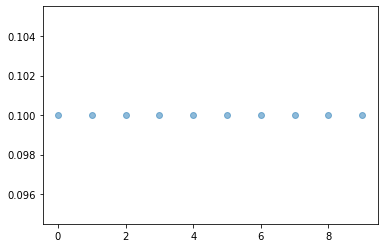

3. S_min gets larger

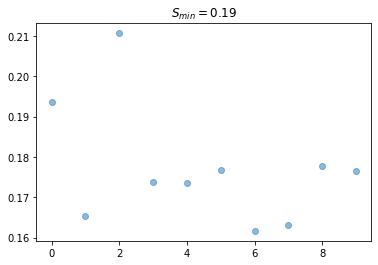

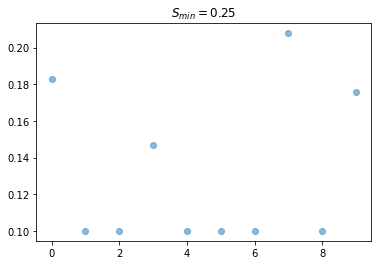

In [14]:
## Question 3.3.2 (Power Control in Wireless Communication)
display(Markdown(r"2. S_min = 0"))
rand.seed(8941966)

# A Pyomo model for the Power Control in Wireless Communication
model = pyo.AbstractModel()
model.name = 'Power Control in Wireless Communication'
N = 10
P_min = 0.1
P_max = 5
sigma = 0.2
G = 0.8*np.random.rand(N,N)+0.1
np.fill_diagonal(G, 1)
S_min = 0

# note boundaries of variables and initial condition
model.P = pyo.Var(range(N), bounds=(P_min ,P_max), initialize=P_min)

def objective(model):
    return sum(model.P[i] for i in range(N))

def ineqconstr(model,i):
    return (G[i,i]*model.P[i]) - S_min*(sum(G[i,j]*model.P[j] for j in range(N)) - G[i,i]*model.P[i]) >= S_min*sigma

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
model.ineqconstr = pyo.Constraint(range(N),rule=ineqconstr)

# create an instance of the problem
acommunicationproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
acommunicationproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(acommunicationproblem)

# show results
acommunicationproblem.display()

def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(acommunicationproblem)

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


P_value = disp_soln(acommunicationproblem)

plt.scatter(range(N), P_value[0:N], alpha=0.5)
plt.show()


## Question 3.3.3 (Power Control in Wireless Communication)
display(Markdown(r"3. S_min gets larger"))
rand.seed(8941966)

## S_min = 0.19
# A Pyomo model for the Power Control in Wireless Communication
model = pyo.AbstractModel()
model.name = 'Power Control in Wireless Communication 1'
N = 10
P_min = 0.1
P_max = 5
sigma = 0.2
G = 0.8*np.random.rand(N,N)+0.1
np.fill_diagonal(G, 1)
S_min = 0.19

# note boundaries of variables and initial condition
model.P = pyo.Var(range(N), bounds=(P_min ,P_max), initialize=P_min)

def objective(model):
    return sum(model.P[i] for i in range(N))

def ineqconstr(model,i):
    return (G[i,i]*model.P[i]) - S_min*(sum(G[i,j]*model.P[j] for j in range(N)) - G[i,i]*model.P[i]) >= S_min*sigma

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
model.ineqconstr = pyo.Constraint(range(N),rule=ineqconstr)

# create an instance of the problem
acommunicationproblem1 = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
acommunicationproblem1.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(acommunicationproblem1)
# show results
acommunicationproblem1.display()
P_value = disp_soln(acommunicationproblem1)

plt.scatter(range(N), P_value[0:N], alpha=0.5)
plt.title('$S_{min} = 0.19$')
plt.show()

## S_min = 0.25
# A Pyomo model for the Power Control in Wireless Communication
model = pyo.AbstractModel()
model.name = 'Power Control in Wireless Communication 2'
N = 10
P_min = 0.1
P_max = 5
sigma = 0.25
G = 0.8*np.random.rand(N,N)+0.1
np.fill_diagonal(G, 1)
S_min = 0.25

# note boundaries of variables and initial condition
model.P = pyo.Var(range(N), bounds=(P_min ,P_max), initialize=P_min)

def objective(model):
    return sum(model.P[i] for i in range(N))

def ineqconstr(model,i):
    return (G[i,i]*model.P[i]) - S_min*(sum(G[i,j]*model.P[j] for j in range(N)) - G[i,i]*model.P[i]) >= S_min*sigma

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
model.ineqconstr = pyo.Constraint(range(N),rule=ineqconstr)

# create an instance of the problem
acommunicationproblem2 = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
acommunicationproblem2.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(acommunicationproblem2)
# show results
acommunicationproblem2.display()
P_value = disp_soln(acommunicationproblem2)

plt.scatter(range(N), P_value[0:N], alpha=0.5)
plt.title('$S_{min} = 0.25$')
plt.show()

1.  Lagrangian: $L(\lambda, \mu_i, x_i) = \Sigma_{i=1}^N P_i + \Sigma_{i=1}^N \mu_{1i}(-\frac{G_{ii}P_i}{\sigma_i + \Sigma_{k\ne i} G_{ik}P_k} + S_{min}) + \Sigma_{i=1}^N \mu_{2i}(P_{min} - P_i) + \Sigma_{i=1}^N \mu_{3i} (P_i-P_{max})$<br/>
KKT conditions: <br/>
$N - \mu_{1i}G_{ii} -\mu_{2i} + \mu_{3i} = 0$<br/>
$\mu_{1i} \ge 0$ <br/>
$\mu_{2i} \ge 0$ <br/>
$\mu_{3i} \ge 0$ <br/>
$\mu_{1i} (-\frac{G_{ii}P_i}{\sigma_i + \Sigma_{k\ne i} G_{ik}P_k} + S_{min}) = 0$ <br/>
$\mu_{2i}(P_{min} - P_i)  = 0$ <br/>
$\mu_{3i} (P_i-P_{max})= 0$ <br/>

3. If we choose a very large $S_{min}$, the solver would converge to a locally infeasible point which means we cannot get a feasible solution.

1. Constrained Optimisation

Model 1. Constrained Optimisation

  Variables:
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     2 :   2.0 :     4 : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   5.0

  Constraints:
    None
Duals
x 2.0
obj 5.0


2. Penalty Optimisation

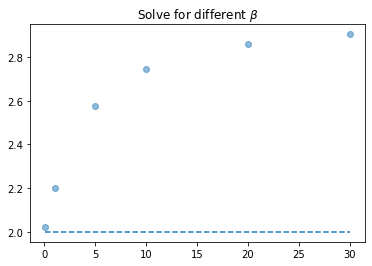

In [15]:
## Question 3.4.1 (Constrained Optimisation)
display(Markdown(r"1. Constrained Optimisation"))
rand.seed(8941966)

# A Pyomo model for the Constrained Optimisation
model = pyo.AbstractModel()
model.name = '1. Constrained Optimisation'

# note boundaries of variables and initial condition
model.x = pyo.Var(bounds=(2,4), initialize=2)

def objective(model):
    return model.x**2 + 1

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

# create an instance of the problem
aconstrainedproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
aconstrainedproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(aconstrainedproblem)

# show results
aconstrainedproblem.display()

def display_lagrange(instance):
    # display all duals
    print ("Duals")
    for c in instance.component_objects(pyo.Constraint, active=True):
        print ("   Constraint",c)
        for index in c:
            print ("      ", index, instance.dual[c[index]])

display_lagrange(aconstrainedproblem)

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
        print(v, pyo.value(v))
    print (instance.obj, pyo.value(instance.obj))
    output.append(pyo.value(instance.obj))
    return output


disp_soln(aconstrainedproblem)

## Question 3.4.2 (Penalty Optimisation)
display(Markdown(r"2. Penalty Optimisation"))
rand.seed(8941966)

beta = (0.1, 1, 5, 10, 20, 30)
x_min = []

# Objective
def objective(model):
    return model.x**2 + 1 + model.beta*(-pyo.log(model.x-2) - pyo.log(4-model.x))

# solution
def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))

    output.append(pyo.value(instance.obj))
    return output

def optimize(i):
    # A Pyomo model for the Penalty Optimisation
    model = pyo.AbstractModel()
    # note boundaries of variables and initial condition
    model.beta = beta[i]
    model.x = pyo.Var(initialize=3)
    model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

    # create an instance of the problem
    apenaltyproblem = model.create_instance()

    # define solver
    opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well
    results = opt.solve(apenaltyproblem)
    sol = disp_soln(apenaltyproblem)

    return sol

for i in range(len(beta)):
    sol = optimize(i)
    x_min.append(sol[0])

plt.scatter(beta, x_min, alpha=0.5)
plt.hlines(2, min(beta), max(beta),linestyles='dashed')
plt.title(r'Solve for different $\beta$')
plt.show()


1. Objective: $f(x) = x^2 + 1$<br/>
Decision variable(s):  $x$<br/>
Constrains: $2 \le x \le 4$

2. If $\beta$ we choose is too large, the minimizer we get will be far from the real optimisation solution.


3. MPC

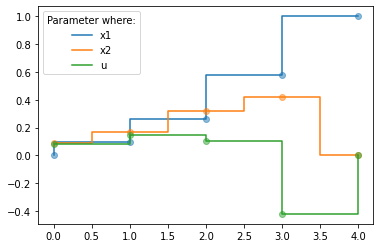

$f_{min} = 1.471554$

In [16]:
## Question 3.5.3 (MPC)
display(Markdown(r"3. MPC"))
rand.seed(8941966)

# A Pyomo model for MPC
model = pyo.AbstractModel()
model.name = '3. MPC'

# note boundaries of variables and initial condition
T = 5
alpha = 0.5
beta = 1
model.x1 = pyo.Var(range(T), bounds=(-1,1), initialize=0)
model.x2 = pyo.Var(range(T), bounds=(-1,1), initialize=0)
model.mu = pyo.Var(range(T), bounds=(-0.5,0.5), initialize=0)

def objective(model):
    return alpha*sum(model.x1[i]**2 for i in range(T-1)) + alpha*sum(model.x2[i]**2 for i in range(T-1)) + alpha*sum(model.mu[i]**2 for i in range(T-1)) +beta*(model.x1[T-1]**2 + model.x2[T-1]**2 + model.mu[T-1]**2)

def eqconstr1(model,i):
    return model.x1[i+1] == model.x1[i] + model.x2[i]

def eqconstr2(model,i):
    return model.x2[i+1] == model.x2[i] + model.mu[i]

def eqconstr3(model):
    return model.x1[T-1] == 1

def eqconstr4(model):
    return model.x2[T-1] == 0


model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
model.eqconstr1 = pyo.Constraint(range(T-1), rule=eqconstr1)
model.eqconstr2 = pyo.Constraint(range(T-1), rule=eqconstr2)
model.eqconstr3 = pyo.Constraint(rule=eqconstr3)
model.eqconstr4 = pyo.Constraint(rule=eqconstr4)

# create an instance of the problem
aMPCproblem = model.create_instance()

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(aMPCproblem)

# show results
#aconstrainedproblem.display()

def disp_soln(instance):
    output = []
    for v in instance.component_data_objects(pyo.Var, active=True):
        output.append(pyo.value(v))
    output.append(pyo.value(instance.obj))
    return output


output = disp_soln(aMPCproblem)
x1 = output[0:T]
x2 = output[T:2*T]
mu = output[2*T:3*T]
func_value = output[3*T]

x = np.arange(T)

plt.step(x, x1, label='x1')
plt.plot(x, x1, 'C0o', alpha=0.5)

plt.step(x, x2, where='mid', label='x2')
plt.plot(x, x2, 'C1o', alpha=0.5)

plt.step(x, mu, where='post', label='u')
plt.plot(x, mu, 'C2o', alpha=0.5)

plt.legend(title='Parameter where:')
plt.show()

display(Markdown(r"$f_{min} = %f$"%(func_value)))

1. Considering a double integrator: $\ddot{y} = u$.<br/>
We have: $\dot{x}(t) = \begin{bmatrix} 0 & 1\\
0 & 0
\end{bmatrix} x(t) +
\begin{bmatrix} 0 \\
1
\end{bmatrix} u(t)$.<br/>
By discretising, we have: $x((k+1)T) = (I + TA)x(kT) + TBu(kT)$.<br/>
Assuming T = 1 and k = t, we finally have:<br/>
$x_{t+1} = \begin{bmatrix} 1 & 1\\
0 & 1
\end{bmatrix} x_t +
\begin{bmatrix} 0 \\
1
\end{bmatrix} u_t$<br/>

2. Minimize $\Sigma_{t=1}^{T-1} \alpha(||x_t||^2 + ||x_t||^2) + \beta ||x_T||^2$<br/>
Subject to: <br/>
$-1 \le x_t \le 1$ <br/>
$-0.5 \le u_t \le 0.5$ <br/>
$x_T = \begin{bmatrix} 1 \\
0
\end{bmatrix}$ <br/>
Assume $\alpha = 0.5$, $\beta = 1$ and $T=5$.